In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import wandb
import random
import os

# === 시드 고정 ===
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === 데이터 로드 함수 ===
def load_and_preprocess_data(file_path, add_next_open=False):
    try:
        df_raw = pd.read_csv(file_path, header=None)
        data = df_raw.iloc[3:].copy()
        data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date').reset_index(drop=True)
        cols = ['Close', 'High', 'Low', 'Open', 'Volume']
        for col in cols:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        data = data.dropna()

        if add_next_open:
            data['Next_Open'] = data['Open'].shift(-1)
            data = data.dropna()
            feature_cols = ['Open', 'High', 'Low', 'Volume', 'Close', 'Next_Open']
        else:
            feature_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
        return data, feature_cols
    except Exception as e:
        print(f"Error: {e}")
        return None, []

# === Dataset 클래스 ===
class CryptoDataset(Dataset):
    def __init__(self, data, seq_len, is_regression=True, feature_cols=None):
        self.seq_len = seq_len
        self.is_regression = is_regression
        self.scaler = MinMaxScaler()
        self.data_scaled = self.scaler.fit_transform(data[feature_cols].values)
        self.close_col_idx = feature_cols.index('Close')

    def __len__(self):
        return len(self.data_scaled) - self.seq_len

    def __getitem__(self, idx):
        x = self.data_scaled[idx : idx + self.seq_len]
        target = self.data_scaled[idx + self.seq_len]
        if self.is_regression:
            y = target[self.close_col_idx]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        else:
            current_close = x[-1, self.close_col_idx]
            next_close = target[self.close_col_idx]
            y = 1.0 if next_close > current_close else 0.0
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# === 모델 정의 ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

class SelfAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, dim_feedforward=hidden_size*4, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze(1)

# === 학습 및 평가 헬퍼 함수 ===
def train_experiment(model, loader, val_loader, criterion, optimizer, epochs, is_regression, name):
    run = wandb.init(project="Crypto_Homework4", name=name, reinit=True)
    model.train()
    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Log (간략화)
        if (epoch+1) % 20 == 0:
            wandb.log({"train_loss": loss.item()})
            print(f"[{name}] Epoch {epoch+1}: Loss {loss.item():.4f}")
    run.finish()

def predict_plot(model, dataset, title):
    model.eval()
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    preds, actuals = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            preds.extend(model(x).cpu().numpy())
            actuals.extend(y.numpy())

    plt.figure(figsize=(10,4))
    plt.plot(actuals, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

# 파라미터 공통 설정
FILE_NAME = 'BTC_KRW_2025_11_30.csv'
SEQ = 21
VAL = 150
TEST = 30
BATCH = 64
EPOCHS = 100
LR = 0.001

Using device: cpu


# 1번문제

===== [문제 1] Baseline Execution =====

--- 1. Regression Baseline ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 (2)


wandb: WARNING Invalid choice
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jjw122601 (jjw122601-koreatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[P1_Reg_Baseline] Epoch 20: Loss 0.0001
[P1_Reg_Baseline] Epoch 40: Loss 0.0001
[P1_Reg_Baseline] Epoch 60: Loss 0.0000
[P1_Reg_Baseline] Epoch 80: Loss 0.0001
[P1_Reg_Baseline] Epoch 100: Loss 0.0001


train_loss,▂█▁▅▂
train_loss,5e-05


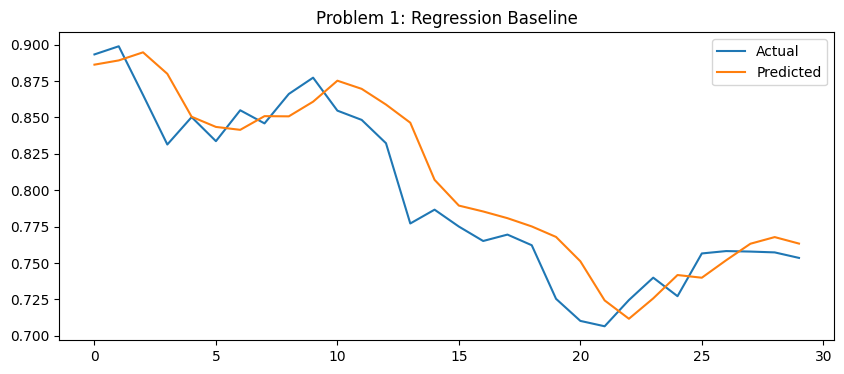


--- 2. Classification Baseline ---


[P1_Cls_Baseline] Epoch 20: Loss 0.6998
[P1_Cls_Baseline] Epoch 40: Loss 0.6956
[P1_Cls_Baseline] Epoch 60: Loss 0.6979
[P1_Cls_Baseline] Epoch 80: Loss 0.6972
[P1_Cls_Baseline] Epoch 100: Loss 0.6865


train_loss,█▆▇▇▁
train_loss,0.68653


In [15]:
print("===== [문제 1] Baseline Execution =====")

# 1. 데이터 준비
df, feats = load_and_preprocess_data(FILE_NAME, add_next_open=False)
dataset = CryptoDataset(df, SEQ, is_regression=True, feature_cols=feats)
total = len(dataset)
train_idx = range(0, total - VAL - TEST)
test_idx = range(total - TEST, total)

train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, range(total - VAL - TEST, total - TEST))
test_set = torch.utils.data.Subset(dataset, test_idx)
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH)

# 1-1. Regression Baseline
print("\n--- 1. Regression Baseline ---")
model_reg = LSTMModel(len(feats), 16, 1).to(device) # Layers=1, Hidden=16
opt = optim.Adam(model_reg.parameters(), lr=LR)
train_experiment(model_reg, train_loader, val_loader, nn.MSELoss(), opt, EPOCHS, True, "P1_Reg_Baseline")
predict_plot(model_reg, test_set, "Problem 1: Regression Baseline")

# 1-2. Classification Baseline
print("\n--- 2. Classification Baseline ---")
ds_cls = CryptoDataset(df, SEQ, is_regression=False, feature_cols=feats)
tr_cls = torch.utils.data.Subset(ds_cls, train_idx)
vl_cls = torch.utils.data.Subset(ds_cls, range(total - VAL - TEST, total - TEST))
tr_loader_cls = DataLoader(tr_cls, batch_size=BATCH, shuffle=True)
vl_loader_cls = DataLoader(vl_cls, batch_size=BATCH)

model_cls = LSTMModel(len(feats), 16, 1).to(device)
opt_cls = optim.Adam(model_cls.parameters(), lr=LR)
train_experiment(model_cls, tr_loader_cls, vl_loader_cls, nn.BCEWithLogitsLoss(), opt_cls, EPOCHS, False, "P1_Cls_Baseline")

# 2번문제

===== [문제 2] Optimized Hyperparameters =====

--- Optimized Regression ---


[P2_Reg_Optimized] Epoch 20: Loss 0.0004
[P2_Reg_Optimized] Epoch 40: Loss 0.0001
[P2_Reg_Optimized] Epoch 60: Loss 0.0003
[P2_Reg_Optimized] Epoch 80: Loss 0.0004
[P2_Reg_Optimized] Epoch 100: Loss 0.0001


train_loss,█▁▆█▃
train_loss,0.00014


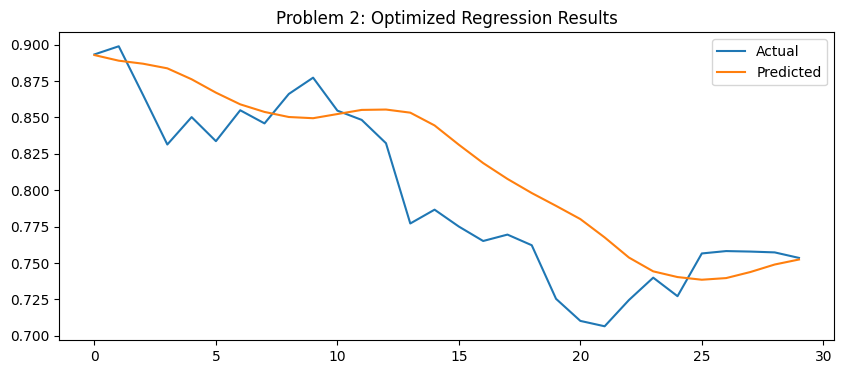


--- Optimized Classification ---


[P2_Cls_Optimized] Epoch 20: Loss 0.6928
[P2_Cls_Optimized] Epoch 40: Loss 0.6937
[P2_Cls_Optimized] Epoch 60: Loss 0.6884
[P2_Cls_Optimized] Epoch 80: Loss 0.6826
[P2_Cls_Optimized] Epoch 100: Loss 0.6976


train_loss,▆▆▄▁█
train_loss,0.69759


In [16]:
print("===== [문제 2] Optimized Hyperparameters =====")
# 튜닝 설정: Hidden=64, Layers=2, Dropout=0.2, Weight Decay=1e-4

# 2-1. Optimized Regression
print("\n--- Optimized Regression ---")
model_opt = LSTMModel(len(feats), 64, 2, dropout=0.2).to(device)
opt_opt = optim.Adam(model_opt.parameters(), lr=LR, weight_decay=1e-4)
train_experiment(model_opt, train_loader, val_loader, nn.MSELoss(), opt_opt, EPOCHS, True, "P2_Reg_Optimized")
predict_plot(model_opt, test_set, "Problem 2: Optimized Regression Results")

# 2-2. Optimized Classification
print("\n--- Optimized Classification ---")
model_cls_opt = LSTMModel(len(feats), 64, 2, dropout=0.2).to(device)
opt_cls_opt = optim.Adam(model_cls_opt.parameters(), lr=LR, weight_decay=1e-4)
train_experiment(model_cls_opt, tr_loader_cls, vl_loader_cls, nn.BCEWithLogitsLoss(), opt_cls_opt, EPOCHS, False, "P2_Cls_Optimized")

# 3번문제

===== [문제 3] Feature Added (Next_Open) =====
Features used: ['Open', 'High', 'Low', 'Volume', 'Close', 'Next_Open']

--- Regression with Next_Open ---


[P3_Reg_NextOpen] Epoch 20: Loss 0.0003
[P3_Reg_NextOpen] Epoch 40: Loss 0.0002
[P3_Reg_NextOpen] Epoch 60: Loss 0.0003
[P3_Reg_NextOpen] Epoch 80: Loss 0.0001
[P3_Reg_NextOpen] Epoch 100: Loss 0.0001


train_loss,█▅▇▁▁
train_loss,0.00013


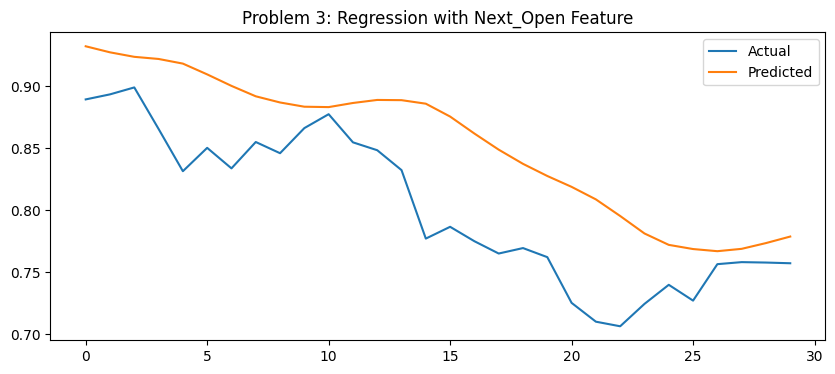

In [17]:
print("===== [문제 3] Feature Added (Next_Open) =====")

# 1. 새로운 데이터 로드 (Next_Open 추가)
df_new, feats_new = load_and_preprocess_data(FILE_NAME, add_next_open=True)
print(f"Features used: {feats_new}")

# 2. 데이터셋 재구성
ds_new = CryptoDataset(df_new, SEQ, is_regression=True, feature_cols=feats_new)
total_new = len(ds_new)
train_idx_new = range(0, total_new - VAL - TEST)
test_set_new = torch.utils.data.Subset(ds_new, range(total_new - TEST, total_new))
train_loader_new = DataLoader(torch.utils.data.Subset(ds_new, train_idx_new), batch_size=BATCH, shuffle=True)
val_loader_new = DataLoader(torch.utils.data.Subset(ds_new, range(total_new - VAL - TEST, total_new - TEST)), batch_size=BATCH)

# 3. Regression 학습 (Feature 추가됨)
print("\n--- Regression with Next_Open ---")
model_new = LSTMModel(len(feats_new), 64, 2, dropout=0.2).to(device)
opt_new = optim.Adam(model_new.parameters(), lr=LR, weight_decay=1e-4)
train_experiment(model_new, train_loader_new, val_loader_new, nn.MSELoss(), opt_new, EPOCHS, True, "P3_Reg_NextOpen")

# 4. 결과 비교 그래프
predict_plot(model_new, test_set_new, "Problem 3: Regression with Next_Open Feature")

# (Classification 비교도 필요하다면 동일한 방식으로 진행)

# 4번문제

===== [문제 4 Optional] Self-Attention Model =====

--- Self-Attention Regression ---


[P4_Reg_SelfAttention] Epoch 20: Loss 0.0006
[P4_Reg_SelfAttention] Epoch 40: Loss 0.0005
[P4_Reg_SelfAttention] Epoch 60: Loss 0.0003
[P4_Reg_SelfAttention] Epoch 80: Loss 0.0004
[P4_Reg_SelfAttention] Epoch 100: Loss 0.0003


train_loss,█▆▁▃▂
train_loss,0.00034


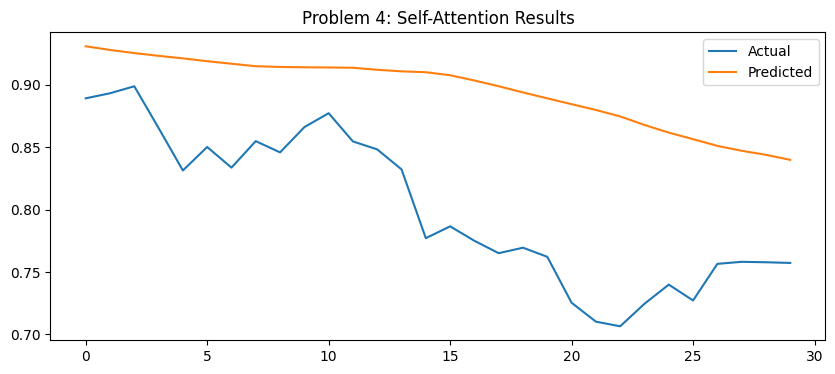

In [18]:
print("===== [문제 4 Optional] Self-Attention Model =====")

# Self-Attention 모델 학습 (Feature 추가된 데이터 사용)
print("\n--- Self-Attention Regression ---")
model_att = SelfAttentionModel(len(feats_new), 64, 2, dropout=0.2).to(device)
opt_att = optim.Adam(model_att.parameters(), lr=LR, weight_decay=1e-4)

train_experiment(model_att, train_loader_new, val_loader_new, nn.MSELoss(), opt_att, EPOCHS, True, "P4_Reg_SelfAttention")

# 결과 확인
predict_plot(model_att, test_set_new, "Problem 4: Self-Attention Results")